In [240]:
# this note book tryin to implement modeling for the GP with derivative information
# the function is considered in this experiment have 2 variables

import torch
import gpytorch
import math
from matplotlib import cm
from matplotlib import pyplot as plt

import numpy as np

%matplotlib inline

In [174]:
#define the function
# function specific: https://www.sfu.ca/~ssurjano/franke2d.html

def franke(X, Y):
    # function term
    term1 = .75*torch.exp(-((9*X - 2).pow(2) + (9*Y - 2).pow(2))/4)
    term2 = .75*torch.exp(-((9*X + 1).pow(2))/49 - (9*Y + 1)/10)
    term3 = .5*torch.exp(-((9*X - 7).pow(2) + (9*Y - 3).pow(2))/4)
    term4 = .2*torch.exp(-(9*X - 4).pow(2) - (9*Y - 7).pow(2))

    # func value
    f = term1 + term2 + term3 + term4

    #taking the derivative information
    dfx = -2*(9*X - 2)*9/4 * term1 - 2*(9*X + 1)*9/49 * term2 + \
          -2*(9*X - 7)*9/4 * term3 + 2*(9*X - 4)*9 * term4
    dfy = -2*(9*Y - 2)*9/4 * term1 - 9/10 * term2 + \
          -2*(9*Y - 3)*9/4 * term3 + 2*(9*Y - 7)*9 * term4

    return f, dfx, dfy

In [176]:
torch.linspace(0, 1, 10).shape

torch.Size([10])

In [178]:
# first we define the training data for about 100 points in range of [0,1] & [0,1] for both dim
# uniform distributed points per dimension
#creating the grid of coordinates

xv, yv = torch.meshgrid(torch.linspace(0, 1, 10), torch.linspace(0, 1, 10), indexing="ij")
# getting a meshgrid xv holds for the x coordinate, yv for the y-coordinate
# xv, yv like a (10x10) grid of (x,y) points covering the square [0,1]x[0,1]

In [180]:
xv.shape

torch.Size([10, 10])

In [182]:
yv.shape

torch.Size([10, 10])

In [184]:
train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1), 
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
) #flatten the xv and yv then cat through the second dim (side by side) 

## return the grid as the cartesian product between two tensor torch.linspace(0,1,10) with the same tensor

In [186]:
xv.contiguous().view(xv.numel(), 1).shape

torch.Size([100, 1])

In [188]:
# x = torch.tensor([1, 2, 3])
# y = torch.tensor([4, 5, 6])

In [190]:
# x.shape

In [192]:
# grid_x, grid_y = torch.meshgrid(x, y, indexing='xy')

In [194]:
# grid_x

In [196]:
# grid_y

In [198]:
# torch.cartesian_prod(x, y)

In [200]:
# torch.cat(tuple(torch.dstack([grid_x, grid_y])))

In [202]:
# torch.dstack([grid_x, grid_y]).shape

In [204]:
# tuple(torch.dstack([grid_x, grid_y]))

In [206]:
f, dfx, dfy = franke(train_x[:, 0], train_x[:, 1])

In [208]:
torch.stack([f, dfx, dfy], -1).shape

torch.Size([100, 3])

In [210]:
# pass a list of 3 tensors each shpae (N,)
# -> stack by add a new dim at the end and put each of these there
train_y = torch.stack([f, dfx, dfy], -1).squeeze(1)

In [212]:
train_y

tensor([[ 7.6642e-01,  6.6927e-01,  3.1509e-01],
        [ 8.1652e-01,  1.7129e+00,  4.2548e-01],
        [ 8.2030e-01,  2.2833e+00, -4.8994e-01],
        [ 7.0746e-01,  1.7530e+00, -1.4103e+00],
        [ 5.4721e-01,  7.4984e-01, -1.3147e+00],
        [ 4.3238e-01,  1.1360e-01, -7.5556e-01],
        [ 3.6997e-01, -8.8562e-02, -4.1939e-01],
        [ 3.3072e-01, -1.1650e-01, -3.0916e-01],
        [ 2.9880e-01, -1.0945e-01, -2.6981e-01],
        [ 2.7034e-01, -9.9295e-02, -2.4334e-01],
        [ 8.4032e-01,  5.0763e-01,  1.3711e+00],
        [ 1.0208e+00,  1.6319e+00,  1.5379e+00],
        [ 1.0962e+00,  2.2535e+00, -4.6064e-01],
        [ 9.1829e-01,  1.7083e+00, -2.4640e+00],
        [ 6.3417e-01,  6.6024e-01, -2.3114e+00],
        [ 4.4093e-01, -1.0756e-03, -1.1727e+00],
        [ 3.5396e-01, -2.0435e-01, -5.0174e-01],
        [ 3.1173e-01, -2.2441e-01, -3.0491e-01],
        [ 2.8111e-01, -2.0663e-01, -2.5471e-01],
        [ 2.5428e-01, -1.8683e-01, -2.2893e-01],
        [ 8.4077e-01

In [214]:
# adding the noise for the data

train_y += 0.05 * torch.randn(train_y.size())

In [216]:
# define the model

class GPWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        # cosntruct the parents class of the GPWithDerivatives
        super(GPWithDerivatives, self).__init__(train_x, train_y, likelihood)

        # construct the mean module of the GPwith Derivative
        self.mean_module = gpytorch.means.ConstantMeanGrad()

        # construct the base kernel of the GP with derivative
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(ard_num_dims=2) #using different lengthscale for derivarive

        # define the scaled kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x) #return the prior

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3) #define the likelihood function

model = GPWithDerivatives(train_x, train_y, likelihood) #we got the first prior
        

In [218]:
## train model
max_iters = 300
#switch model to the mode train

model.train()
likelihood.train() # train the likelihood since they also depends on the noise variance


# define the optimizer
optimier = torch.optim.Adam(model.parameters(), lr=0.03)

# define the loss function
 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) # construct the marginal likelihood
# compute the marginal likelihood of the function (actually the log)

# training procedure
for i in range(max_iters):
    optimier.zero_grad()

    output = model(train_x) #get the f prior

    loss = -mll(output, train_y) #forward pass to compute the marginal likelihood

    loss.backward()

    # print out the marginal likelihood results and params optimize and noise
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
        i + 1, max_iters, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.likelihood.noise.item()
    ))

    optimier.step()

Iter 1/200 - Loss: 1.277   lengthscales: 0.693, 0.693   noise: 0.693
Iter 2/200 - Loss: 1.268   lengthscales: 0.678, 0.678   noise: 0.678
Iter 3/200 - Loss: 1.259   lengthscales: 0.664, 0.664   noise: 0.664
Iter 4/200 - Loss: 1.250   lengthscales: 0.649, 0.649   noise: 0.649
Iter 5/200 - Loss: 1.240   lengthscales: 0.635, 0.635   noise: 0.635
Iter 6/200 - Loss: 1.231   lengthscales: 0.621, 0.621   noise: 0.621
Iter 7/200 - Loss: 1.221   lengthscales: 0.607, 0.607   noise: 0.607
Iter 8/200 - Loss: 1.211   lengthscales: 0.593, 0.594   noise: 0.594
Iter 9/200 - Loss: 1.201   lengthscales: 0.579, 0.581   noise: 0.580
Iter 10/200 - Loss: 1.191   lengthscales: 0.566, 0.568   noise: 0.567
Iter 11/200 - Loss: 1.181   lengthscales: 0.553, 0.555   noise: 0.554
Iter 12/200 - Loss: 1.170   lengthscales: 0.539, 0.542   noise: 0.541
Iter 13/200 - Loss: 1.159   lengthscales: 0.526, 0.530   noise: 0.529
Iter 14/200 - Loss: 1.148   lengthscales: 0.513, 0.518   noise: 0.517
Iter 15/200 - Loss: 1.137   l

In [220]:
# plot and eval

model.eval()

GPWithDerivatives(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-04)
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (mean_module): ConstantMeanGrad()
  (base_kernel): RBFKernelGrad(
    (raw_lengthscale_constraint): Positive()
  )
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernelGrad(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [222]:
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [230]:
# initialize plots

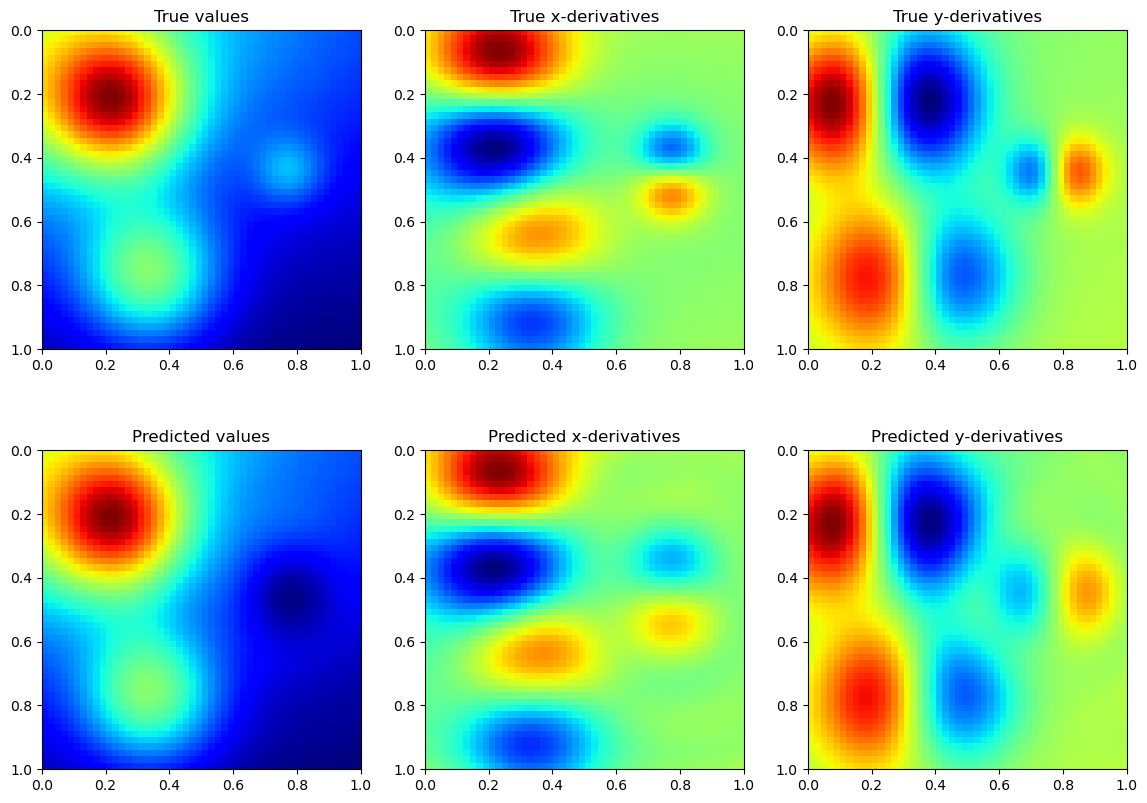

In [250]:
# test points
# already change the model and likelihood to the eval mode
n1, n2 = 50, 50
xv, yv = torch.meshgrid(torch.linspace(0, 1, n1), torch.linspace(0,1, n2), indexing="ij")
f, dfx, dfy = franke(xv, yv) # getting the trth 

# prediction
fig, ax = plt.subplots(2, 3, figsize=(14, 10))

with torch.no_grad():
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1) # construct the input set as grid
    # model(test_x) -> get the model posterior p(f*|x*, X, y) - (uncertainty here just model uncertainty form GP)
    # likelihood compute distribution over function (noisy prediction) - p(y*|x*,X,y)
    predictions = likelihood(model(test_x)) # geting the distribution by multiply the prior wiht likelihood
    mean = predictions.mean

f_true_np   = f.detach().cpu().numpy()
dfx_true_np = dfx.detach().cpu().numpy()
dfy_true_np = dfy.detach().cpu().numpy()

mean_np = mean.detach().cpu().numpy()
pred_f   = mean_np[:, 0].reshape(n1, n2)
pred_dfx = mean_np[:, 1].reshape(n1, n2)
pred_dfy = mean_np[:, 2].reshape(n1, n2)

# extent for imshow
extent = (
    float(xv.min()), float(xv.max()),
    float(yv.max()), float(yv.min())
)

#truth
ax[0, 0].imshow(f_true_np, extent=extent, cmap=cm.jet)
ax[0, 0].set_title('True values')

ax[0, 1].imshow(dfx_true_np, extent=extent, cmap=cm.jet)
ax[0, 1].set_title('True x-derivatives')

ax[0, 2].imshow(dfy_true_np, extent=extent, cmap=cm.jet)
ax[0, 2].set_title('True y-derivatives')

#preds
ax[1, 0].imshow(pred_f, extent=extent, cmap=cm.jet)
ax[1, 0].set_title('Predicted values')

ax[1, 1].imshow(pred_dfx, extent=extent, cmap=cm.jet)
ax[1, 1].set_title('Predicted x-derivatives')

ax[1, 2].imshow(pred_dfy, extent=extent, cmap=cm.jet)
ax[1, 2].set_title('Predicted y-derivatives')

plt.show()

## Somenote
- The normal procedure for define a GP models with GPytorch is:

- (1) Define the data (input data need to be in the form) X in R^p - Y with y in R^d
Tensor with 2 dim
- (2) Adding the noise to the true value of the function we want to model
- (3) Define our own model:

    + First create the model by inherit the Gpytorhc.models.ExactGP if we doing exact inference. This handles most of the inference

    + In the __init__ method for the model for sure -> make sure also construct the parent object using the params also (make sure we feed the arguments that needed is the train_data, train_label, and the likelihood func/ same as the params for init our own model)
 
        + Define the *mean* function (normally using ConstantMeanGrad() for grad estimate)
        + Define the *base_kernel* function (based on the problem)
        + Since some kernel does not have the scale params -> wraping the based kernel by scaled version

    + Define the forward() method take the input as the x values:
        + This method of our created model overwirte the parents & design for compute the mean & the cov
        + Return the distribution of MultitaskMultivariateNormal(mean, cov)

- (4) Define the likelihood function we use:
    + Construct likelihood instant using the build in likelihood object with specific number of task
- (5) Define our Model instant with input, output and likelihood instant just define

- (6) Define the loss function (here create the loss func as an instant using the exact marginal likelihood). It takes the *likelihood* and *model* we defined before as the argument for construction

- (7) Training process:
    + Define the optimizer: Adam, LBFGS etc
    + Using the same process as normal Pytorch training procedure:
    + Loop through the iter
    + Zero the gradient
    + Compute the prior by forwarding the model() and getting the multivariate normal distri
    + From the output of the model -> adapt the mll and training observation to compute the marginal likelihood
    + Backward the loss (backward the mll)
    + Print out some loss, information if needed
    + optimizer.step() to add a step, process until reaching the limit iterations

- (8) Prediction:
    + create the prediction input set (its just tensor in 2d)
    + The *model(test_x)* returns the model posterior distribution *p(f\*|x\*,x,y)* for training data x, y
    + prediction is feed into the likelihood *pred = likelihood(model(x_test))) gives us posterior predictive distribution over the predicted output value
    + Getting the *mean = pred.mean* and *cov = pred.confidence_region*